In [22]:
from collections import defaultdict as dd

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
from scipy.stats import ttest_ind
from numba import njit, jit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from scipy.stats import entropy

In [2]:
meta = pd.read_csv('../data/reduced/meta_01.csv')
print(meta['plat'].unique())
meta.head()

['Agilent' 'Illumina_NGS' 'Affymetrix_U133' 'Illumina_Chip'
 'Affymetrix_HUG' 'Affymetrix_PRV']


,CN,type,plat,TP
0,C_189,Solid tumor,Agilent,Solid tumor_Agilent
1,C_1764,Solid tumor,Agilent,Solid tumor_Agilent
2,C_1741,Solid tumor,Agilent,Solid tumor_Agilent
3,C_4556,Solid tumor,Agilent,Solid tumor_Agilent
4,C_3776,Solid tumor,Agilent,Solid tumor_Agilent


In [3]:
data = pd.read_csv('../data/reduced/DESeq2_01.csv')
data.columns = meta['CN']
data = data.astype(float).T

In [4]:
data.head()

,A2M,AACS,AAK1,AAMP,AANAT,AASDHPPT,AASS,AATF,AATK,ABAT,...,ZSCAN2,ZSWIM1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDC,ZYX,ZZEF1,ZZZ3
CN,,,,,,,,,,,,,,,,,,,,,
C_189,13409.232939,1211.026306,14.993659,2847.065177,135.231271,3041.694404,290.069634,3496.982627,113.605801,449.809771,...,89.096935,143.881459,1409.692288,1092.518731,7727.501188,19.607093,407.135510,592.537871,573.219118,929.030180
C_1764,14292.127154,1290.137629,30.284921,2951.097289,288.379746,2928.551848,260.450319,3426.570546,126.523669,501.047191,...,86.143775,137.964639,1117.850079,1343.304490,6672.777564,21.535944,339.527613,750.729538,652.471795,824.086347
C_1741,13684.675623,1130.859917,40.562391,2579.377114,597.195686,1993.421608,368.971148,2845.231822,239.464719,511.672573,...,168.602710,129.506430,788.278758,1336.115390,4836.698616,29.810914,339.648938,1054.133466,591.819948,1041.915878
C_4556,19807.193076,1593.901874,12.741022,3981.569430,54.149344,2559.671355,255.457495,4224.922954,98.105871,449.758083,...,87.276002,98.105871,1382.400906,1274.739269,7012.658606,12.741022,361.207979,939.013334,445.298725,640.873415
C_3776,17281.523132,1432.289198,13.436109,4519.011258,177.356636,1988.544102,317.987908,3662.683257,201.541632,435.329925,...,113.759054,100.322946,732.715800,968.295574,8815.878851,21.497774,311.717724,1178.794612,481.012695,755.109314


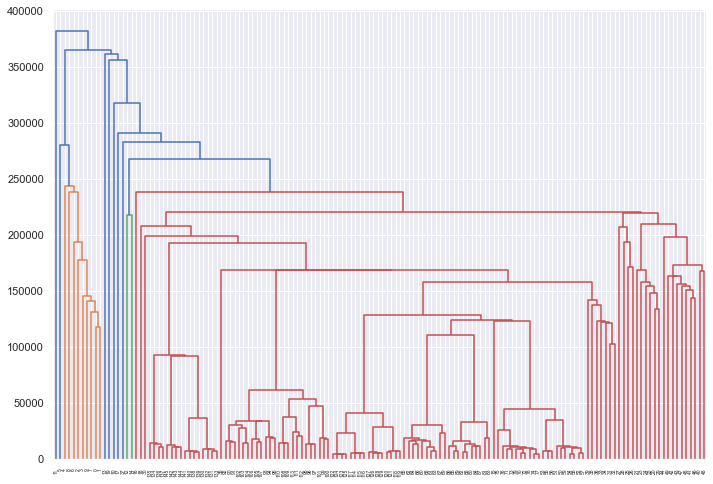

In [5]:
Z = hierarchy.linkage(data, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)

In [51]:
tree = hierarchy.to_tree(Z)
head_id = tree.id

def find_children(tree):
    values = tree.pre_order(lambda x: x.id)
    pair = dd(list)
    pair[tree.id] = values
    
    if not tree.left.is_leaf():
        pair.update(find_children(tree.left))
    if not tree.right.is_leaf():
        pair.update(find_children(tree.right))
        
    return pair

child_clusters = find_children(tree)

In [52]:
sorted_nodes = sorted(tree.pre_order(lambda x: x), key=lambda x: x.dist, reverse=True)

In [53]:
a = []
def find_childrenn(tree):
    a.append(tree)
    
    if not tree.left.is_leaf():
        find_childrenn(tree.left)
    if not tree.right.is_leaf():
        find_childrenn(tree.right)
        
find_childrenn(tree)

In [54]:
sorted_a = sorted(a, key=lambda x: x.dist, reverse=True)

In [55]:
def find_subclusters(tree):
    pair = dd(list)
    
    if not tree.left.is_leaf():
        pair[ tree.id].append( tree.left.id)
        pair.update(find_subclusters(tree.left))
    else:
        pair[ tree.id].append(None)
    if not tree.right.is_leaf():
        pair[ tree.id].append( tree.right.id)
        pair.update(find_subclusters(tree.right))
    else:
        pair[ tree.id].append(None)
        
    return pair

subcluster_clusters = find_subclusters(tree)

In [56]:
label_clusters = {k: meta.iloc[v]['plat'].values for k, v in child_clusters.items()}

In [65]:
def calc_entropy(labels):
    counts = np.unique(labels, return_counts=True)[1]
    return entropy(counts)

entropy_clusters = dd(float)
entropy_clusters.update({k: calc_entropy(v) for k, v in label_clusters.items()})

In [66]:
k = 1
a = 2
- k/a * np.log(k/a) - (1 - k/a) * np.log(1 - k/a)

0.6931471805599453

In [67]:
def information_gain(parent, left, right):
    if entropy_clusters[parent] == 0:
        return 1
    
    N = len(child_clusters[parent])

    if left is not None:
        n_l = len(child_clusters[left])
        entropy_l = entropy_clusters[left]
    else:
        n_l = 1
        entropy_l = 0
        
    if right is not None:
        n_r = len(child_clusters[right])
        entropy_r = entropy_clusters[right]
    else:
        n_r = 1
        entropy_r = 0
    print(entropy_clusters[parent], entropy_l, entropy_r, n_l / N * entropy_l / entropy_clusters[parent], n_r / N * entropy_r / entropy_clusters[parent])
    return 1 - (n_l / N * entropy_l / entropy_clusters[parent] + n_r / N * entropy_r / entropy_clusters[parent])

ig_clusters = {k: information_gain(k, left, right) for k, (left, right) in subcluster_clusters.items()}

1.602803189007172 0 1.607690041513806 0.0 0.9961787428661365
1.607690041513806 0.0 1.4572341436122 0.0 0.843903490176925
1.4572341436122 0 1.4618959856016887 0.0 0.9957679984440732
1.4618959856016887 0 1.466554400570078 0.0 0.995700090212524
1.466554400570078 0 1.4712074438570384 0.0 0.995630119950043
1.4712074438570384 0 1.4758530354233697 0.0 0.9955579933511285
1.4758530354233697 0 1.4804889502588567 0.0 0.9954836102424054
1.4804889502588567 0.0 1.489722061752916 0.0 0.9907559664976949
1.489722061752916 0 1.4943139858283225 0.0 0.9952458219417496
1.4943139858283225 1.2567611867145763 0.0 0.7085833695209204 0.0
1.2567611867145763 0 1.2615779496646051 0.0 0.9944510657622165
1.2615779496646051 0 1.2663858201818625 0.0 0.994341082511713
1.2663858201818625 0.0 0.9905025934219388 0.0 0.6629645180170544
0.9905025934219388 0 0.9949236325717752 0.0 0.9931773242039433
0.9949236325717752 0.0 0.5623351446188083 0.0 0.41105769415796894
0.5623351446188083 0.5936148767694077 0.0 0.9401657617916396 

In [68]:
len(ig_clusters)

145

In [69]:
a, b = list(zip(*sorted(list(ig_clusters.items()))))

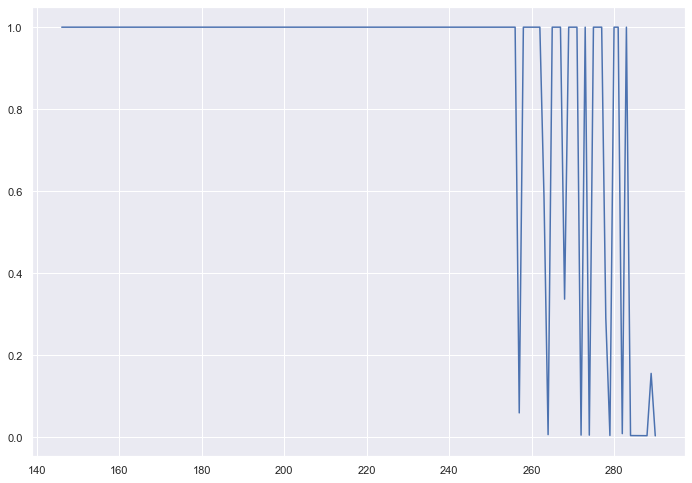

In [70]:
plt.plot(a, b)

In [71]:
len(sorted_nodes)

146

In [90]:

def information_gain(parent_node):
    parent = parent_node.id
    if parent_node.is_leaf():
        return 1
        
    left = parent_node.left.id
    right = parent_node.right.id
    
    if entropy_clusters[parent] == 0:
        return 1
    
    N = len(child_clusters[parent])

    if left is not None:
        n_l = len(child_clusters[left])
        entropy_l = entropy_clusters[left]
    else:
        n_l = 1
        entropy_l = 0
        
    if right is not None:
        n_r = len(child_clusters[right])
        entropy_r = entropy_clusters[right]
    else:
        n_r = 1
        entropy_r = 0
    print(entropy_clusters[parent], entropy_l, entropy_r, n_l / N * entropy_l / entropy_clusters[parent], n_r / N * entropy_r / entropy_clusters[parent])
    return 1 - (n_l / N * entropy_l / entropy_clusters[parent] + n_r / N * entropy_r / entropy_clusters[parent])

ig_list = list(map(information_gain, sorted_a))

1.602803189007172 0.0 1.607690041513806 0.0 0.9961787428661365
1.607690041513806 0.0 1.4572341436122 0.0 0.843903490176925
1.4572341436122 0.0 1.4618959856016887 0.0 0.9957679984440732
1.4618959856016887 0.0 1.466554400570078 0.0 0.995700090212524
1.466554400570078 0.0 1.4712074438570384 0.0 0.995630119950043
1.4712074438570384 0.0 1.4758530354233697 0.0 0.9955579933511285
1.4758530354233697 0.0 1.4804889502588567 0.0 0.9954836102424054
1.4804889502588567 0.0 1.489722061752916 0.0 0.9907559664976949
1.489722061752916 0.0 1.4943139858283225 0.0 0.9952458219417496
1.4943139858283225 1.2567611867145763 0.0 0.7085833695209204 0.0
1.2567611867145763 0.0 1.2615779496646051 0.0 0.9944510657622165
1.2615779496646051 0.0 1.2663858201818625 0.0 0.994341082511713
1.2663858201818625 0.0 0.9905025934219388 0.0 0.6629645180170544
0.9905025934219388 0.0 0.9949236325717752 0.0 0.9931773242039433
0.9949236325717752 0.0 0.5623351446188083 0.0 0.41105769415796894
0.5623351446188083 0.5936148767694077 0.0

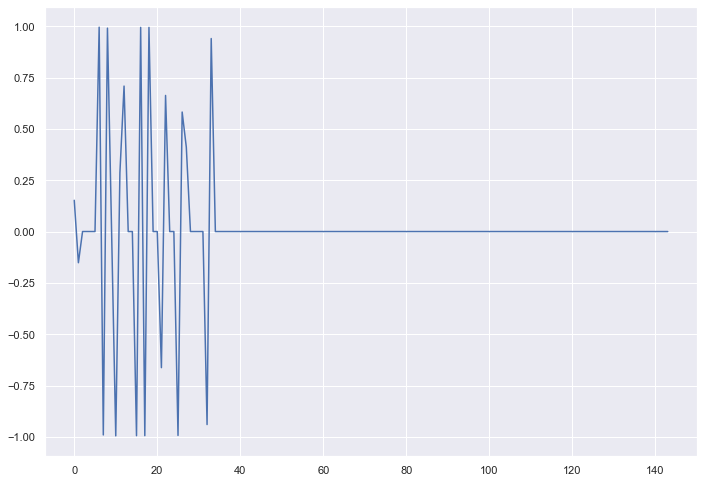

In [105]:
plt.plot(np.array(ig_list)[1:] - np.array(ig_list)[0:-1])

In [95]:
cum = [0]
for i, node in enumerate(sorted_a):
    cum.append(cum[-1] + node.count / data.shape[0] * ig_list[i])

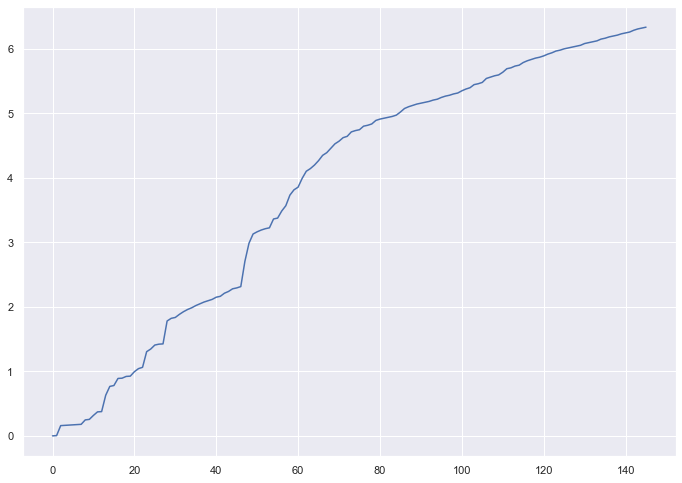

In [97]:
plt.plot(cum)

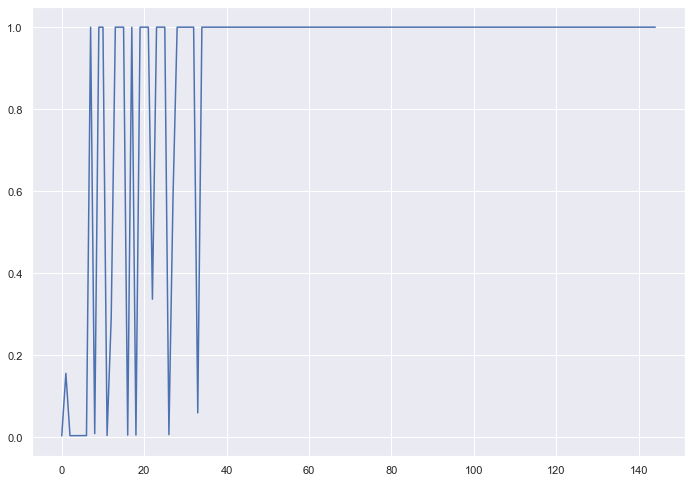

In [93]:
plt.plot(ig_list)